# Model Logistic Regression, SVM , Naive Bayes

In [ ]:
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

# # Replace with your downloaded file path
# file_path = "/content/kh_sentimental_data_cleaned_V2.csv"

# Read CSV safely
df = pd.read_csv("/content/kh_sentimental_data_cleaned_V2.csv", encoding='utf-8')  # use utf-8 first
# If it fails, try:
# df = pd.read_csv(file_path, encoding='utf-8-sig')

# Check first rows
print(df.head())

                                                text  label
0  នាយិកាមជ្ឈមណ្ឌលសិទ្ធិមនុស្សកម្ពុជាអ្នកស្រី ចក់...      2
1  ការឃុំខ្លួនកញ្ញា សេង ធារី កាន់តែយូរដោយរដ្ឋាភិប...      1
2  ប្រភពបង្ហើបថា បន្ទប់នោះមានខ្ទង់ចំណាយប្រមាណជាង ...      2
3  1956បានបង្ហាញថាផូស្វ័របានផ្ទេរចេញពីដើមបែកអារទៅ...      2
4  ដរាបណាយើងមិនបានតាំងចិត្តខិតខំប្រឹងរៀន ប្រឹងធ្វ...      0


In [ ]:
df

,text,label
0,នាយិកាមជ្ឈមណ្ឌលសិទ្ធិមនុស្សកម្ពុជាអ្នកស្រី ចក់...,2
1,ការឃុំខ្លួនកញ្ញា សេង ធារី កាន់តែយូរដោយរដ្ឋាភិប...,1
2,ប្រភពបង្ហើបថា បន្ទប់នោះមានខ្ទង់ចំណាយប្រមាណជាង ...,2
3,1956បានបង្ហាញថាផូស្វ័របានផ្ទេរចេញពីដើមបែកអារទៅ...,2
4,ដរាបណាយើងមិនបានតាំងចិត្តខិតខំប្រឹងរៀន ប្រឹងធ្វ...,0
...,...,...
22415,រំពឹងមានការបញ្ជាទិញបន្តនៅឆ្នាំ២០២៦,1
22416,កម្ពុជាដាំដុះស្វាយចន្ទីលើផ្ទៃដី៦៣ម៉ឺនហិកតា,2
22417,ទិន្នផលស្វាយចន្ទីរហូតដល់៩៥ម៉ឺនតោនក្នុងមួយឆ្នាំ,2
22418,កម្ពុជាជាប្រទេសផលិតចន្ទីស្រស់លំដាប់ទី២ពិភពលោក,1


In [ ]:
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


Dataset shape: (22420, 2)
Columns: ['text', 'label']


In [ ]:
# Class Distribution Analysis
class_counts = df['label'].value_counts().sort_index()
class_names = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
print(f"\nCLASS DISTRIBUTION (Total: {len(df)} samples):")
for label, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"Class {label} ({class_names[label]}): {count} samples ({percentage:.1f}%)")



CLASS DISTRIBUTION (Total: 22420 samples):
Class 0 (Negative): 9166 samples (40.9%)
Class 1 (Positive): 12004 samples (53.5%)
Class 2 (Neutral): 1250 samples (5.6%)


In [ ]:
# Check for missing values
print(f"\nDATA QUALITY:")
print(f"Missing values in text: {df['text'].isnull().sum()}")
print(f"Missing values in label: {df['label'].isnull().sum()}")

# Text Length Analysis
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print(f"\nTEXT STATISTICS:")
print(f"Average characters: {df['text_length'].mean():.1f}")
print(f"Average words: {df['word_count'].mean():.1f}")
print(f"Min characters: {df['text_length'].min()}")
print(f"Max characters: {df['text_length'].max()}")



DATA QUALITY:
Missing values in text: 0
Missing values in label: 0

TEXT STATISTICS:
Average characters: 201.8
Average words: 7.4
Min characters: 6
Max characters: 8504


# KHMER TEXT PREPROCESSING

In [ ]:
# Language Detection
def detect_khmer(text):
    """Check if text contains Khmer characters"""
    if not isinstance(text, str):
        return False
    khmer_pattern = re.compile(r'[\u1780-\u17ff]')
    return bool(khmer_pattern.search(text))

df['has_khmer'] = df['text'].apply(detect_khmer)
print(f"\nLANGUAGE ANALYSIS:")
print(f"Contains Khmer: {df['has_khmer'].sum()} ({df['has_khmer'].mean()*100:.1f}%)")



LANGUAGE ANALYSIS:
Contains Khmer: 22420 (100.0%)


In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00


In [ ]:
class KhmerTextPreprocessor:
    """Enhanced Khmer text preprocessing for 3-class sentiment"""

    # Khmer stopwords (expand as needed)
    KHMER_STOPWORDS = {
        'និង', 'ដែល', 'ជា', 'មួយ', 'នេះ', 'របស់', 'ថា', 'បាន', 'ពី',
        'ដល់', 'ក្នុង', 'អោយ', 'គេ', 'ខ្ញុំ', 'ឯង', 'គាត់', 'នាង',
        'ពួក', 'ពួកគេ', 'យើង', 'ដោយ', 'តែ', 'ឬ', 'ក៏', 'ប៉ុន្តែ'
    }

    @staticmethod
    def normalize_unicode(text):
        """Normalize Khmer Unicode characters"""
        if not isinstance(text, str):
            return ""
        return unicodedata.normalize('NFC', text)

    @staticmethod
    def remove_special_chars(text):
        """Remove non-Khmer special characters"""
        # Keep Khmer, numbers, basic punctuation and spaces
        text = re.sub(r'[^ក-៿០-៩\s.,!?០១២៣៤៥៦៧៨៩0-9]', ' ', text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    @staticmethod
    def normalize_numbers(text):
        """Normalize Khmer and Arabic numbers"""
        khmer_to_arabic = {
            '០': '0', '១': '1', '២': '2', '៣': '3', '៤': '4',
            '៥': '5', '៦': '6', '៧': '7', '៨': '8', '៩': '9'
        }
        for khmer, arabic in khmer_to_arabic.items():
            text = text.replace(khmer, arabic)
        return text

    @staticmethod
    def khmer_tokenizer(text):
        """Simple tokenizer for Khmer text by splitting on spaces"""
        if not isinstance(text, str):
            return []
        return text.split()

    @staticmethod
    def clean_text(text):
        """Complete text cleaning pipeline"""
        if not isinstance(text, str):
            return ""
             # Apply all cleaning steps
        text = KhmerTextPreprocessor.normalize_unicode(text)
        text = KhmerTextPreprocessor.normalize_numbers(text)
        text = KhmerTextPreprocessor.remove_special_chars(text)

        return text


        # Apply preprocessing
df['cleaned_text'] = df['text'].apply(KhmerTextPreprocessor.clean_text)

# Remove empty texts
initial_count = len(df)
df = df[df['cleaned_text'].str.strip() != '']
final_count = len(df)
print(f"Removed {initial_count - final_count} empty texts")
print(f"Remaining samples: {final_count}")

# Show sample cleaned texts
print("\nSample cleaned texts by class:")
for label in sorted(df['label'].unique()):
    print(f"\n{class_names[label]} (Class {label}):")
    samples = df[df['label'] == label].head(2)
    for idx, row in samples.iterrows():
        print(f"  Original: {row['text'][:60]}")
        print(f"  Cleaned:  {row['cleaned_text'][:60]}")

Removed 0 empty texts
Remaining samples: 22420

Sample cleaned texts by class:

Negative (Class 0):
  Original: ដរាបណាយើងមិនបានតាំងចិត្តខិតខំប្រឹងរៀន ប្រឹងធ្វើលំហាត់ជារៀងរា
  Cleaned:  ដរាបណាយើងមិនបានតាំងចិត្តខិតខំប្រឹងរៀន ប្រឹងធ្វើលំហាត់ជារៀងរា
  Original: សាលាដំបូងរាជធានីភ្នំពេញបានចោទប្រកាន់លោក សុន ឆ័យ ពីបទបរិហាកេរ
  Cleaned:  សាលាដំបូងរាជធានីភ្នំពេញបានចោទប្រកាន់លោក សុន ឆ័យ ពីបទបរិហាកេរ

Positive (Class 1):
  Original: ការឃុំខ្លួនកញ្ញា សេង ធារី កាន់តែយូរដោយរដ្ឋាភិបាលលោក ហ៊ុន សែន
  Cleaned:  ការឃុំខ្លួនកញ្ញា សេង ធារី កាន់តែយូរដោយរដ្ឋាភិបាលលោក ហ៊ុន សែន
  Original: សូមបញ្ជាក់ថា ក្រុមការងារក្រសួងមហាផ្ទៃបានសហការជាមួយអាជ្ញាធរខេ
  Cleaned:  សូមបញ្ជាក់ថា ក្រុមការងារក្រសួងមហាផ្ទៃបានសហការជាមួយអាជ្ញាធរខេ

Neutral (Class 2):
  Original: នាយិកាមជ្ឈមណ្ឌលសិទ្ធិមនុស្សកម្ពុជាអ្នកស្រី ចក់ សុភាព បង្ហាញខ
  Cleaned:  នាយិកាមជ្ឈមណ្ឌលសិទ្ធិមនុស្សកម្ពុជាអ្នកស្រី ចក់ សុភាព បង្ហាញខ
  Original: ប្រភពបង្ហើបថា បន្ទប់នោះមានខ្ទង់ចំណាយប្រមាណជាង ១០ម៉ឺនដុល្លារអ
  Cleaned:  ប្រភពបង្ហើបថា បន្ទប់នោះមានខ្ទង់ចំណាយប្រមាណជា

 # DATA SPLITTING

In [ ]:
from sklearn.model_selection import train_test_split

# Split data first
X = df['cleaned_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 17936
Test size: 4484


#   Implement TF-IDF Vectorizer


In [ ]:
import math
from collections import defaultdict

class TfidfVectorizer:
    def __init__(self, max_features=5000):
        self.max_features = max_features
        self.vocab = {}
        self.idf = {}

    def fit(self, texts):
        """Build vocabulary and calculate IDF scores"""
        # Count document frequency
        doc_freq = defaultdict(int)
        total_docs = len(texts)

        for text in texts:
            words = set(text.split())
            for word in words:
                doc_freq[word] += 1

        # Select top features
        sorted_words = sorted(doc_freq.items(), key=lambda x: x[1], reverse=True)
        top_words = [word for word, _ in sorted_words[:self.max_features]]

        # Create vocabulary
        self.vocab = {word: idx for idx, word in enumerate(top_words)}

        # Calculate IDF
        for word in self.vocab:
            df = doc_freq.get(word, 0)
            self.idf[word] = math.log((total_docs + 1) / (df + 1)) + 1

        return self

    def transform(self, texts):
        """Convert texts to TF-IDF vectors"""
        vectors = []

        for text in texts:
            # Count term frequency
            words = text.split()
            tf = defaultdict(int)
            for word in words:
                if word in self.vocab:
                    tf[word] += 1

            # Normalize TF
            word_count = len(words)
            if word_count > 0:
                for word in tf:
                    tf[word] /= word_count

            # Create vector
            vector = [0] * len(self.vocab)
            for word, idx in self.vocab.items():
                if word in tf:
                    vector[idx] = tf[word] * self.idf[word]

            vectors.append(vector)

        return np.array(vectors)

In [ ]:
# Create and fit vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Training features shape: {X_train_vec.shape}")
print(f"Testing features shape: {X_test_vec.shape}")

Training features shape: (17936, 1000)
Testing features shape: (4484, 1000)


#  Naive Bayes

In [ ]:
class NaiveBayesFromScratch:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)

        # Calculate class priors
        for cls in self.classes:
            self.class_priors[cls] = np.sum(y == cls) / n_samples

        # Calculate feature probabilities for each class
        self.feature_probs = {cls: {} for cls in self.classes}

        for cls in self.classes:
            X_cls = X[y == cls]

            # Apply Laplace smoothing
            total_words = np.sum(X_cls) + self.alpha * n_features
            self.feature_probs[cls] = {
                'prob': (np.sum(X_cls, axis=0) + self.alpha) / total_words,
                'log_prob': np.log((np.sum(X_cls, axis=0) + self.alpha) / total_words)
            }

    def predict(self, X):
        predictions = []
        for x in X:
            class_scores = {}

            for cls in self.classes:
                # Start with log of prior
                score = np.log(self.class_priors[cls])

                # Add log probabilities of features
                log_probs = self.feature_probs[cls]['log_prob']
                score += np.sum(x * log_probs)

                class_scores[cls] = score

            # Choose class with highest score
            predictions.append(max(class_scores, key=class_scores.get))

        return np.array(predictions)

#  Logistic Regression


In [ ]:
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iters = n_iterations
        self.weights = None
        self.bias = None
        self.classes = None

    def softmax(self, z):
        """Softmax function for multi-class classification"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # One-hot encode y
        y_onehot = np.zeros((n_samples, n_classes))
        for i, cls in enumerate(self.classes):
            y_onehot[y == cls, i] = 1

        # Initialize weights and bias
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        # Gradient descent
        for _ in range(self.n_iters):
            # Forward pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_onehot))
            db = (1 / n_samples) * np.sum(y_pred - y_onehot, axis=0)

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.softmax(linear_model)

# SVM from


In [ ]:
class SVMFromScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        # For multi-class, we'll use One-vs-Rest strategy
        self.classes = np.unique(y)
        self.models = {}

        for cls in self.classes:
            # Create binary labels for this class
            y_binary = np.where(y == cls, 1, -1)

            # Train binary SVM
            n_samples, n_features = X.shape
            self.w = np.zeros(n_features)
            self.b = 0

            for _ in range(self.n_iters):
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                    if condition:
                        self.w -= self.lr * (2 * self.lambda_param * self.w)
                    else:
                        self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_binary[idx]))
                        self.b -= self.lr * y_binary[idx]

            self.models[cls] = (self.w.copy(), self.b)

    def predict(self, X):
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes)))

        for i, cls in enumerate(self.classes):
            w, b = self.models[cls]
            scores[:, i] = np.dot(X, w) - b

        return np.argmax(scores, axis=1)

#. Train and Evaluate Models

In [ ]:
def evaluate_model_from_scratch(y_true, y_pred, model_name=""):
    """
    Comprehensive evaluation metrics from scratch
    """
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)

    # Initialize metrics storage
    metrics = {
        'accuracy': 0,
        'precision': np.zeros(n_classes),
        'recall': np.zeros(n_classes),
        'f1': np.zeros(n_classes),
        'support': np.zeros(n_classes, dtype=int),
        'confusion_matrix': np.zeros((n_classes, n_classes), dtype=int)
    }

    # Calculate confusion matrix
    for true, pred in zip(y_true, y_pred):
        metrics['confusion_matrix'][true, pred] += 1

    # Calculate per-class metrics
    for i, cls in enumerate(classes):
        # True positives, false positives, false negatives
        tp = metrics['confusion_matrix'][i, i]
        fp = np.sum(metrics['confusion_matrix'][:, i]) - tp
        fn = np.sum(metrics['confusion_matrix'][i, :]) - tp

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics['precision'][i] = precision
        metrics['recall'][i] = recall
        metrics['f1'][i] = f1
        metrics['support'][i] = np.sum(y_true == cls)

    # Overall accuracy
    metrics['accuracy'] = np.sum(np.diag(metrics['confusion_matrix'])) / len(y_true)

    # Macro and Weighted averages
    metrics['macro_precision'] = np.mean(metrics['precision'])
    metrics['macro_recall'] = np.mean(metrics['recall'])
    metrics['macro_f1'] = np.mean(metrics['f1'])

    # Weighted averages
    total_samples = np.sum(metrics['support'])
    weights = metrics['support'] / total_samples

    metrics['weighted_precision'] = np.sum(metrics['precision'] * weights)
    metrics['weighted_recall'] = np.sum(metrics['recall'] * weights)
    metrics['weighted_f1'] = np.sum(metrics['f1'] * weights)

    return metrics

def print_detailed_report(metrics, model_name, class_names):
    """
    Print detailed classification report
    """
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION - {model_name.upper()}")
    print(f"{'='*60}")

    print(f"\nOverall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro F1-Score:   {metrics['macro_f1']:.4f}")
    print(f"Weighted F1-Score: {metrics['weighted_f1']:.4f}")

    print(f"\n{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print(f"{'-'*55}")

    for i, cls in enumerate(range(len(class_names))):
        print(f"{class_names[cls]:<15} "
              f"{metrics['precision'][i]:<10.4f} "
              f"{metrics['recall'][i]:<10.4f} "
              f"{metrics['f1'][i]:<10.4f} "
              f"{metrics['support'][i]:<10}")

    print(f"{'-'*55}")
    print(f"{'Macro Avg':<15} "
          f"{metrics['macro_precision']:<10.4f} "
          f"{metrics['macro_recall']:<10.4f} "
          f"{metrics['macro_f1']:<10.4f} "
          f"{np.sum(metrics['support']):<10}")

    print(f"{'Weighted Avg':<15} "
          f"{metrics['weighted_precision']:<10.4f} "
          f"{metrics['weighted_recall']:<10.4f} "
          f"{metrics['weighted_f1']:<10.4f} "
          f"{np.sum(metrics['support']):<10}")

    # Confusion Matrix
    print(f"\nConfusion Matrix:")
    conf_df = pd.DataFrame(
        metrics['confusion_matrix'],
        index=[f"True {class_names[i]}" for i in range(len(class_names))],
        columns=[f"Pred {class_names[i]}" for i in range(len(class_names))]
    )
    print(conf_df.to_string())

    return metrics

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegressionFromScratch(learning_rate=0.01, n_iterations=1000),
    'Naive Bayes': NaiveBayesFromScratch(alpha=1.0),
    'SVM': SVMFromScratch(learning_rate=0.001, lambda_param=0.01, n_iters=500)
}

# Store all evaluation results
all_results = {}

for name, model in models.items():
    print(f"\n{'#'*60}")
    print(f"Training and Evaluating: {name}")
    print(f"{'#'*60}")

    # Train
    model.fit(X_train_vec, y_train)

    # Predict
    y_pred = model.predict(X_test_vec)

    # Calculate all metrics
    metrics = evaluate_model_from_scratch(y_test, y_pred)

    # Print detailed report
    detailed_metrics = print_detailed_report(metrics, name, class_names)

    # Store results
    all_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'metrics': detailed_metrics,
        'accuracy': detailed_metrics['accuracy'],
        'macro_f1': detailed_metrics['macro_f1'],
        'weighted_f1': detailed_metrics['weighted_f1']
    }


############################################################
Training and Evaluating: Logistic Regression
############################################################

COMPREHENSIVE EVALUATION - LOGISTIC REGRESSION

Overall Accuracy: 0.5355
Macro F1-Score:   0.2325
Weighted F1-Score: 0.3735

Class           Precision  Recall     F1-Score   Support   
-------------------------------------------------------
Negative        0.0000     0.0000     0.0000     1833      
Positive        0.5355     1.0000     0.6975     2401      
Neutral         0.0000     0.0000     0.0000     250       
-------------------------------------------------------
Macro Avg       0.1785     0.3333     0.2325     4484      
Weighted Avg    0.2867     0.5355     0.3735     4484      

Confusion Matrix:
               Pred Negative  Pred Positive  Pred Neutral
True Negative              0           1833             0
True Positive              0           2401             0
True Neutral               0            2

# Logistic Regression & SVM are very sensitive to imbalance data.

# Compare Model Performance

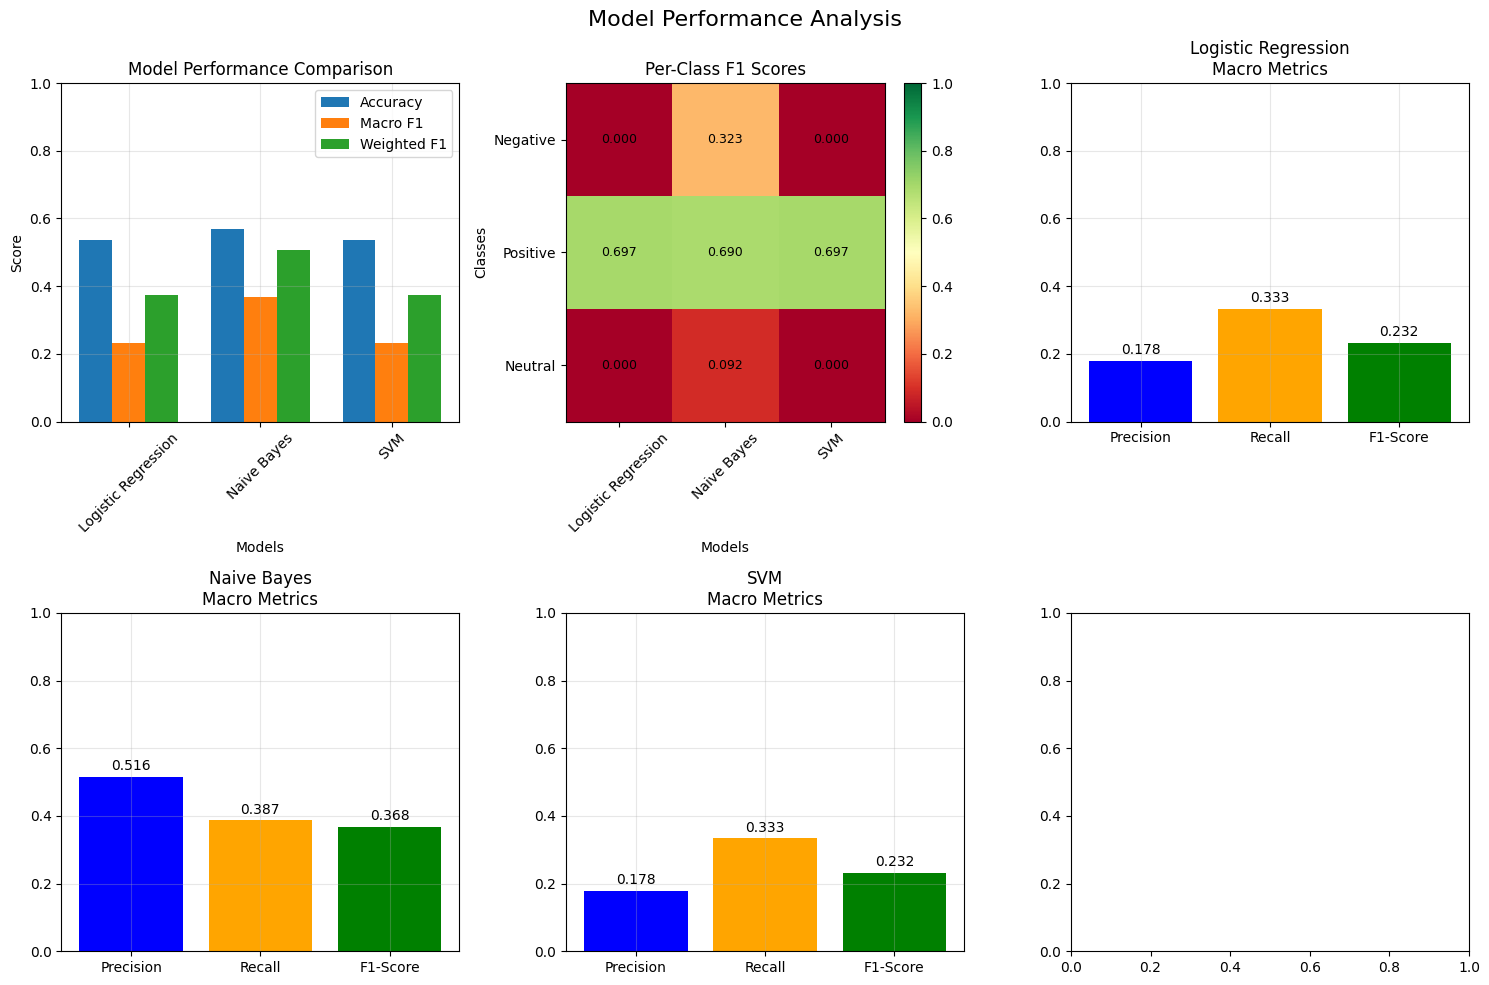

In [ ]:
def compare_models_visually(all_results):
    """
    Create visual comparison of all models
    """
    # Extract metrics for comparison
    model_names = list(all_results.keys())

    # Metrics to compare
    metrics_to_plot = ['accuracy', 'macro_f1', 'weighted_f1', 'macro_precision', 'macro_recall']
    metric_labels = ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Macro Recall']

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # 1. Main metrics bar chart
    main_metrics = ['accuracy', 'macro_f1', 'weighted_f1']
    main_labels = ['Accuracy', 'Macro F1', 'Weighted F1']

    x = np.arange(len(model_names))
    width = 0.25

    for i, (metric, label) in enumerate(zip(main_metrics, main_labels)):
        values = [all_results[name]['metrics'][metric] for name in model_names]
        axes[0].bar(x + i*width - width, values, width, label=label)

    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Model Performance Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(model_names, rotation=45)
    axes[0].legend()
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3)

    # 2. Per-class F1 scores heatmap
    class_f1_scores = np.zeros((len(class_names), len(model_names)))

    for j, model_name in enumerate(model_names):
        for i in range(len(class_names)):
            class_f1_scores[i, j] = all_results[model_name]['metrics']['f1'][i]

    im = axes[1].imshow(class_f1_scores, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Classes')
    axes[1].set_title('Per-Class F1 Scores')
    axes[1].set_xticks(range(len(model_names)))
    axes[1].set_xticklabels(model_names, rotation=45)
    axes[1].set_yticks(range(len(class_names)))
    axes[1].set_yticklabels([class_names[i] for i in range(len(class_names))])

    # Add text annotations
    for i in range(len(class_names)):
        for j in range(len(model_names)):
            text = axes[1].text(j, i, f'{class_f1_scores[i, j]:.3f}',
                            ha="center", va="center", color="black", fontsize=9)

    plt.colorbar(im, ax=axes[1])

    # 3. Precision-Recall bar chart per model
    for idx, model_name in enumerate(model_names):
        metrics = all_results[model_name]['metrics']
        axes[idx+2].bar(['Precision', 'Recall', 'F1-Score'],
                       [metrics['macro_precision'], metrics['macro_recall'], metrics['macro_f1']],
                       color=['blue', 'orange', 'green'])
        axes[idx+2].set_title(f'{model_name}\nMacro Metrics')
        axes[idx+2].set_ylim([0, 1])
        axes[idx+2].grid(True, alpha=0.3)

        # Add value labels
        for i, v in enumerate([metrics['macro_precision'], metrics['macro_recall'], metrics['macro_f1']]):
            axes[idx+2].text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.suptitle('Model Performance Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

    return fig

# Create visual comparison
fig = compare_models_visually(all_results)

# Identify the Best Model

In [ ]:
best_model_name = max(all_results, key=lambda name: all_results[name]['weighted_f1'])
best_accuracy = all_results[best_model_name]['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print("-" * 50)

# Get the best model instance
best_model = all_results[best_model_name]['model']

Best Model: Naive Bayes
Accuracy: 0.5680
--------------------------------------------------


#Detailed Error Analysis on Best Model

In [ ]:
def confusion_matrix_from_scratch(y_true, y_pred, labels):
    """
    Computes a confusion matrix from scratch.
    """
    n_classes = len(labels)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    label_to_idx = {label: i for i, label in enumerate(labels)}

    for true, pred in zip(y_true, y_pred):
        conf_matrix[label_to_idx[true], label_to_idx[pred]] += 1
    return conf_matrix

def detailed_error_analysis(model, X_test_vec, y_test, X_test_raw, vectorizer):
    """
    Perform comprehensive error analysis
    """
    # Get predictions
    y_pred = model.predict(X_test_vec)

    # Get prediction probabilities if available
    try:
        y_proba = model.predict_proba(X_test_vec)
    except:
        y_proba = None

    # Create results DataFrame
    results_df = pd.DataFrame({
        'text': X_test_raw,
        'true_label': y_test,
        'predicted_label': y_pred,
        'is_correct': y_test == y_pred
    })

    # Add class names
    results_df['true_class'] = results_df['true_label'].map(class_names)
    results_df['predicted_class'] = results_df['predicted_label'].map(class_names)

    # Add confidence scores if available
    if y_proba is not None:
        for i, cls in enumerate(sorted(np.unique(y_test))):
            results_df[f'prob_class_{cls}'] = y_proba[:, i]

    return results_df

# Perform error analysis
error_df = detailed_error_analysis(best_model, X_test_vec, y_test, X_test, vectorizer)

# Display error statistics
print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)

# Overall accuracy
accuracy = np.mean(error_df['is_correct'])
print(f"Overall Accuracy: {accuracy:.4f}")

# Class-wise performance
print("\nCLASS-WISE PERFORMANCE:")
for label in sorted(np.unique(y_test)):
    class_data = error_df[error_df['true_label'] == label]
    class_acc = np.mean(class_data['is_correct'])
    class_name = class_names[label]
    print(f"  {class_name} (Class {label}): {len(class_data)} samples, Accuracy: {class_acc:.4f}")

# Confusion Matrix from scratch
print("\nCONFUSION MATRIX:")
conf_matrix = confusion_matrix_from_scratch(y_test, y_pred, sorted(np.unique(y_test)))
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"True {class_names[i]}" for i in sorted(np.unique(y_test))],
    columns=[f"Pred {class_names[i]}" for i in sorted(np.unique(y_test))]
)
print(conf_matrix_df)



ERROR ANALYSIS
Overall Accuracy: 0.5680

CLASS-WISE PERFORMANCE:
  Negative (Class 0): 1833 samples, Accuracy: 0.2220
  Positive (Class 1): 2401 samples, Accuracy: 0.8859
  Neutral (Class 2): 250 samples, Accuracy: 0.0520

CONFUSION MATRIX:
               Pred Negative  Pred Positive  Pred Neutral
True Negative              0           1833             0
True Positive              0           2401             0
True Neutral               0            250             0


# Save the Best Model

In [ ]:
import pickle
import json
import os

def save_model_pipeline(model, vectorizer, preprocessing_class, model_name, save_dir='saved_models'):
    """
    Save the complete model pipeline
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Create model info
    model_info = {
        'model_name': model_name,
        'model_type': type(model).__name__,
        'vectorizer_type': type(vectorizer).__name__,
        'preprocessor_class': preprocessing_class.__name__,
        'accuracy': best_accuracy,
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'classes': {str(k): v for k, v in class_names.items()},
        'vocabulary_size': len(vectorizer.vocab) if hasattr(vectorizer, 'vocab') else None
    }

    # Save components
    save_path = os.path.join(save_dir, model_name)

    # 1. Save model object
    with open(f'{save_path}_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    # 2. Save vectorizer
    with open(f'{save_path}_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

    # 3. Save model info as JSON
    with open(f'{save_path}_info.json', 'w', encoding='utf-8') as f:
        json.dump(model_info, f, ensure_ascii=False, indent=2)

    # 4. Save preprocessing class reference
    with open(f'{save_path}_preprocessor.py', 'w', encoding='utf-8') as f:
        f.write("""
# Preprocessing class for Khmer sentiment analysis
import re
import unicodedata

class KhmerTextPreprocessor:
    KHMER_STOPWORDS = {
        'និង', 'ដែល', 'ជា', 'មួយ', 'នេះ', 'របស់', 'ថា', 'បាន', 'ពី',
        'ដល់', 'ក្នុង', 'អោយ', 'គេ', 'ខ្ញុំ', 'ឯង', 'គាត់', 'នាង',
        'ពួក', 'ពួកគេ', 'យើង', 'ដោយ', 'តែ', 'ឬ', 'ក៏', 'ប៉ុន្តែ'
    }

    @staticmethod
    def clean_text(text):
        \"\"\"Complete text cleaning pipeline\"\"\"
        if not isinstance(text, str):
            return ""
        text = unicodedata.normalize('NFC', text)
        # Add number normalization if needed
        text = re.sub(r'[^ក-៿០-៩\s.,!?០១២៣៤៥៦៧៨៩0-9]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
""")

    print(f"\nModel saved successfully to {save_path}_*")
    print(f"Model Info: {model_info}")

    return save_path

# Save the best model
save_path = save_model_pipeline(
    model=best_model,
    vectorizer=vectorizer,
    preprocessing_class=KhmerTextPreprocessor,
    model_name=f'khmer_sentiment_{best_model_name.lower().replace(" ", "_")}'
)


Model saved successfully to saved_models/khmer_sentiment_naive_bayes_*
Model Info: {'model_name': 'khmer_sentiment_naive_bayes', 'model_type': 'NaiveBayesFromScratch', 'vectorizer_type': 'TfidfVectorizer', 'preprocessor_class': 'KhmerTextPreprocessor', 'accuracy': np.float64(0.5680196253345228), 'timestamp': '2026-01-13 04:39:55', 'classes': {'0': 'Negative', '1': 'Positive', '2': 'Neutral'}, 'vocabulary_size': 1000}


#Create Prediction Function for New Text

In [ ]:
def predict_sentiment(text, model, vectorizer, preprocessor):
    """
    Predict sentiment for new Khmer text
    """
    # Clean the text
    cleaned_text = preprocessor.clean_text(text)

    # Vectorize
    text_vec = vectorizer.transform([cleaned_text])

    # Predict
    prediction = model.predict(text_vec)[0]
    prediction_class = class_names[prediction]

    # Get probabilities if available
    try:
        probabilities = model.predict_proba(text_vec)[0]
        prob_dict = {class_names[i]: float(prob) for i, prob in enumerate(probabilities)}
    except:
        prob_dict = None

    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'predicted_label': int(prediction),
        'predicted_class': prediction_class,
        'probabilities': prob_dict
    }

# Test with sample texts
test_texts = [
    "ខ្ញុំពេញចិត្តខ្លាំងណាស់",  # I'm very satisfied
    "មិនល្អទេ ខូចហើយ",  # Not good, broken
    "ធម្មតា គ្មានអ្វីពិសេសទេ"  # Normal, nothing special
]

print("\n" + "="*50)
print("PREDICTION TEST ON NEW TEXTS")
print("="*50)

for text in test_texts:
    result = predict_sentiment(text, best_model, vectorizer, KhmerTextPreprocessor)
    print(f"\nText: {text}")
    print(f"Prediction: {result['predicted_class']} (Class {result['predicted_label']})")
    if result['probabilities']:
        for cls, prob in result['probabilities'].items():
            print(f"  P({cls}): {prob:.3f}")


PREDICTION TEST ON NEW TEXTS

Text: ខ្ញុំពេញចិត្តខ្លាំងណាស់
Prediction: Positive (Class 1)

Text: មិនល្អទេ ខូចហើយ
Prediction: Positive (Class 1)

Text: ធម្មតា គ្មានអ្វីពិសេសទេ
Prediction: Negative (Class 0)


In [ ]:
!zip -r saved_models.zip saved_models
from google.colab import files
files.download('saved_models.zip')


  adding: saved_models/ (stored 0%)
  adding: saved_models/khmer_sentiment_naive_bayes_preprocessor.py (deflated 45%)
  adding: saved_models/khmer_sentiment_naive_bayes_info.json (deflated 36%)
  adding: saved_models/khmer_sentiment_naive_bayes_vectorizer.pkl (deflated 70%)
  adding: saved_models/khmer_sentiment_naive_bayes_model.pkl (deflated 32%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>